In [1]:
import torch
import matplotlib
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

import utils.model as model
import utils.dataset as dataset
import utils.skel as skel

from utils.dataset import SIGNUMDataset
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

In [2]:
test_dataset = SIGNUMDataset('/scratch/datasets/SIGNUM', use_pose=True, subsample=5)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=test_dataset.collate)

In [3]:
language_encoder = model.language_encoder()

pose_decoder = model.Decoder(hidden_size=768, pose_size=57*2, trajectory_size=57*2,
               use_h=False, start_zero=False, use_tp=True,
               use_lang=False, use_attn=False).to('cuda:0')

for param in language_encoder.parameters():
    param.requires_grad = False

In [4]:
num_joints = 57
joint_dim = 2
num_epochs = 100
loss_fn = torch.nn.L1Loss()
optimizerDecoder = torch.optim.SGD(pose_decoder.parameters(), lr=0.1)

In [5]:
for epoch in range(1):
    for i, data in enumerate(test_dataloader):
        if i == 1:
            break
        optimizerDecoder.zero_grad()
        
        img_seq = torch.FloatTensor(data['img_seq'])
        pose_seq = data['pose_seq'].cuda()
        label_seq = data['label_seq'].cuda()
        transl_eng = data['transl_eng']
        transl_deu = data['transl_deu']
        img_seq_len = data['seq_len']
        
        total_sequence = sum(np.array(img_seq_len))
        delta = label_seq - pose_seq
        
#         print(delta.shape)
#         print(pose_seq.shape)
        initial_delta = torch.zeros_like(delta)
#         print(initial_delta.shape)
        combined = torch.cat((pose_seq, initial_delta), dim=-2)
#         print(combined.shape)
        
        lang_embed = torch.FloatTensor(language_encoder(transl_eng)).cuda()

        # For use TP!
        output = pose_decoder(lang_embed, max(img_seq_len), combined.view(combined.shape[0], combined.shape[1], -1),\
                              epoch=epoch)
        print('output: ', output.shape)
#         output = pose_decoder(lang_embed, max(img_seq_len), pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1),\
#                               epoch=epoch)
        packed = dataset.pack_sequence(output, np.array(img_seq_len))
        pred_pose = packed.data.view(-1,num_joints*joint_dim*2)
#         print(pred_pose)
        
#         print(pred_pose)
#         print(pred_pose.shape)
#         print(lens_unpacked)
#         print(pred_pose.shape)

        combined_label = torch.cat((label_seq, delta), dim=-2)
#         print(combined_label.shape)
        pack_gted = dataset.pack_sequence(combined_label, np.array(img_seq_len))
        gt_label = pack_gted.data.view(-1, num_joints*joint_dim*2)
        
        print('gt label: ', gt_label.shape)
#         print(gt_label.shape)

#         print(viz_gt)
#         print(len_gt)

#         gt_label = dataset.unpad_sequence(label_seq, np.array(img_seq_len)).data.view(-1, num_joints*joint_dim)
        
        
#         gt_label = dataset.unpad_sequence(delta, np.array(img_seq_len)).data.view(-1, num_joints*joint_dim)
        attention = torch.ones_like(gt_label)
        attention[1:7,...] *= 2.5
        attention[:,15:] *= 1.5

        print('attention: ', attention.shape)
        loss = loss_fn(pred_pose*attention, gt_label*attention)
#         loss = loss_fn(denorm_output, denorm_label)
        loss.backward()
        optimizerDecoder.step()
        print(epoch, loss)

output:  torch.Size([4, 47, 228])
gt label:  torch.Size([132, 228])
attention:  torch.Size([132, 228])
0 tensor(0.6277, device='cuda:0', grad_fn=<L1LossBackward>)


In [6]:
viz, len_viz  = dataset.unpad_sequence(packed)
viz_gt, len_gt = dataset.unpad_sequence(pack_gt)
# print(viz.shape)
vis_pose = viz[0,:len_viz[0],:].view(-1, num_joints*joint_dim, 2)[:,:num_joints, :].detach().cpu()
vis_gt = viz_gt[0,:len_gt[0], :num_joints, ...].detach().cpu()
print(vis_pose.shape)
print(vis_gt.shape)

torch.Size([4, 47, 228])
torch.Size([47, 57, 2])
torch.Size([47, 57, 2])


47
0


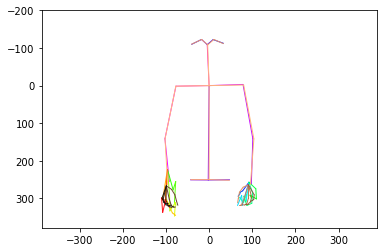

1


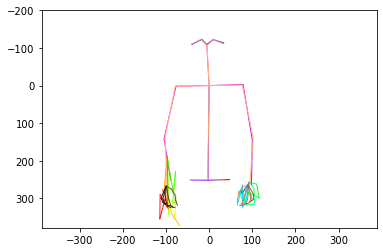

2


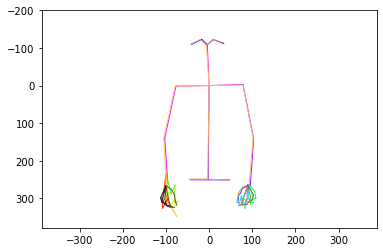

3


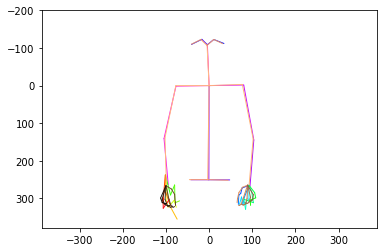

4


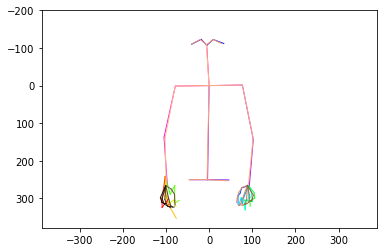

5


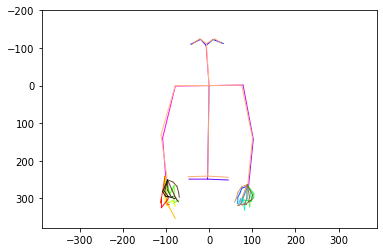

6


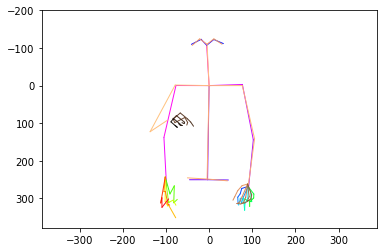

7


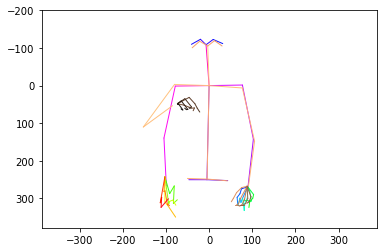

8


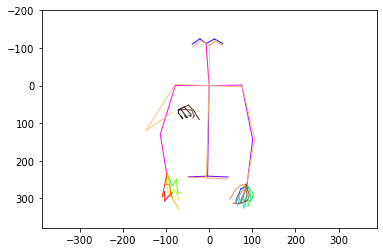

9


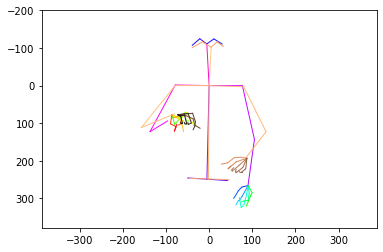

10


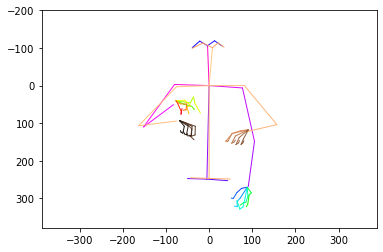

11


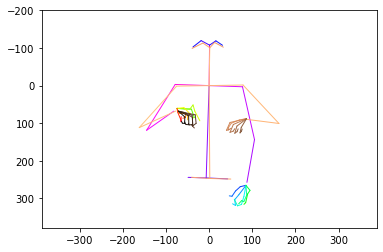

12


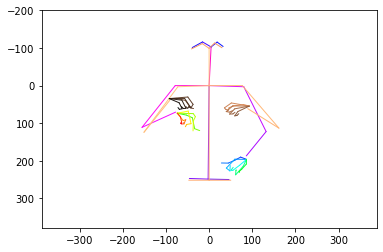

13


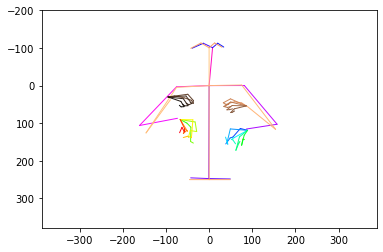

14


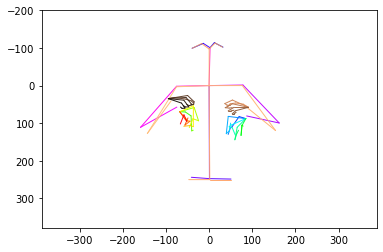

15


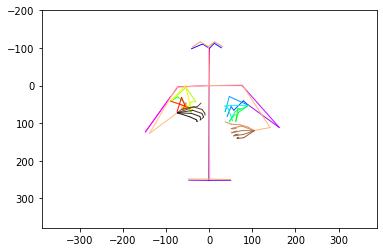

16


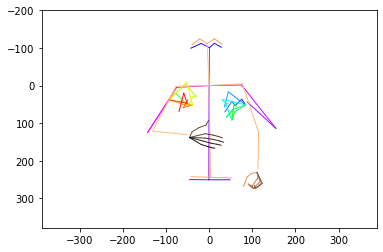

17


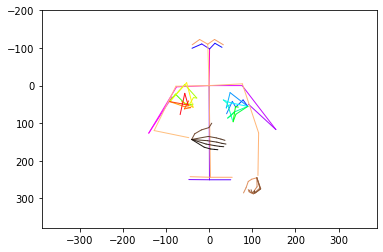

18


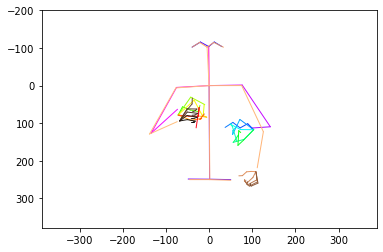

19


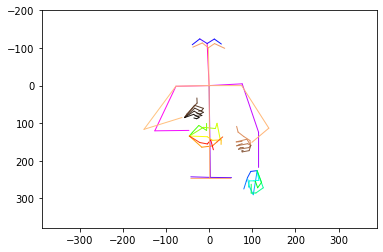

20


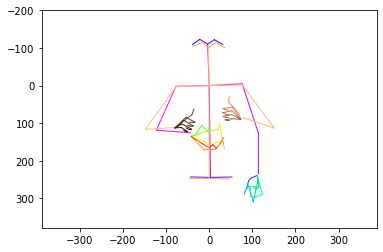

21


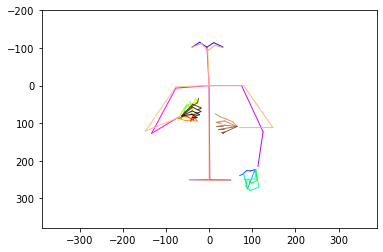

22


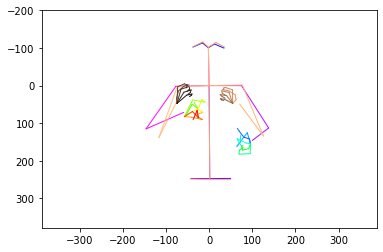

23


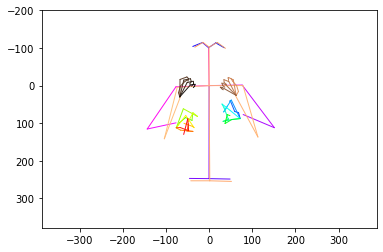

24


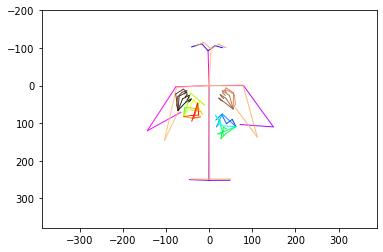

25


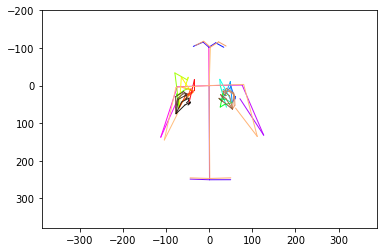

26


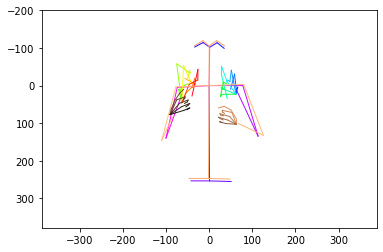

27


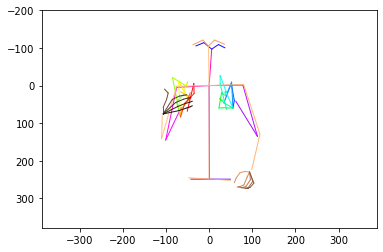

28


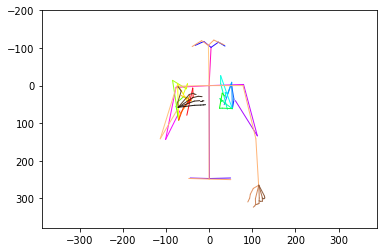

29


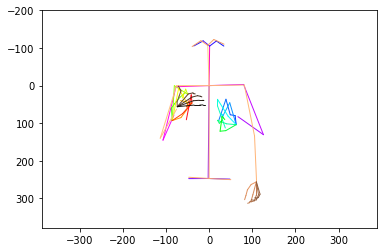

30


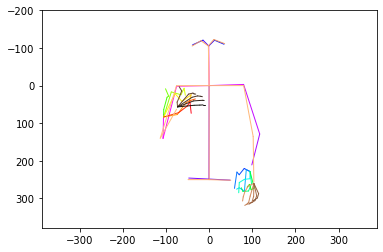

31


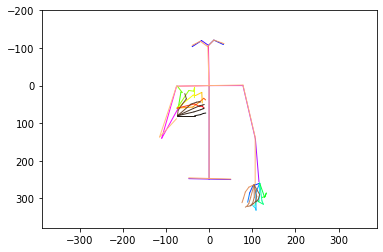

32


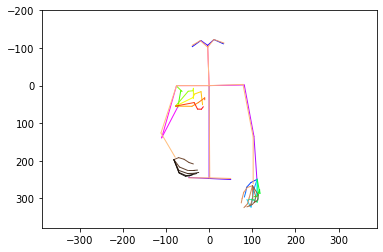

33


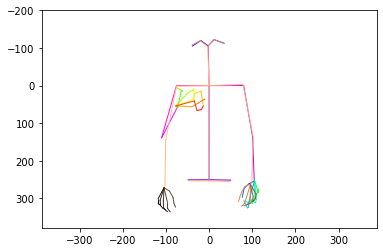

34


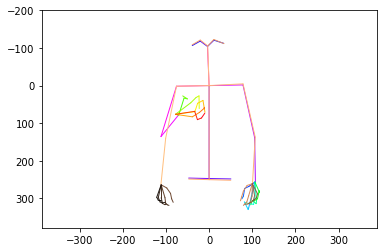

35


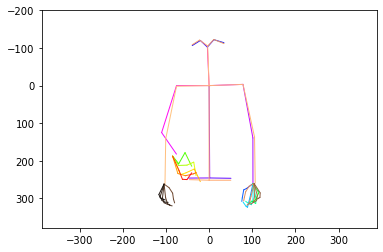

36


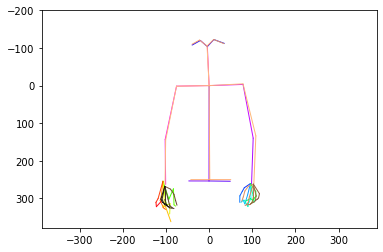

37


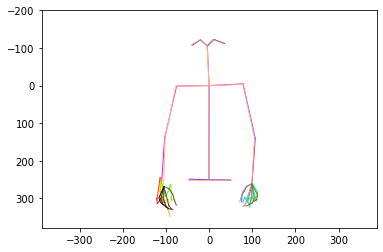

38


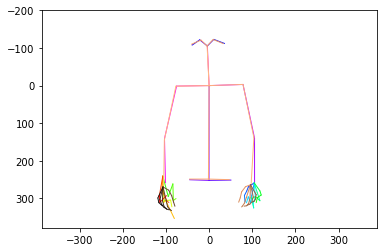

39


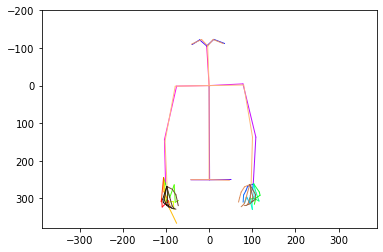

40


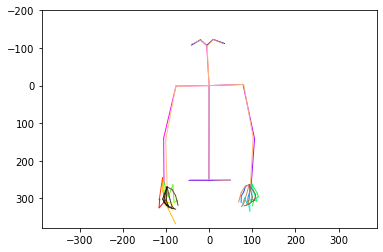

41


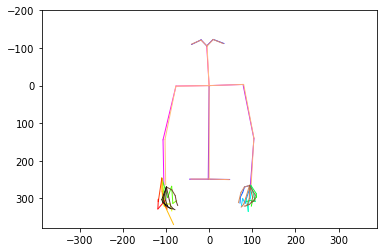

42


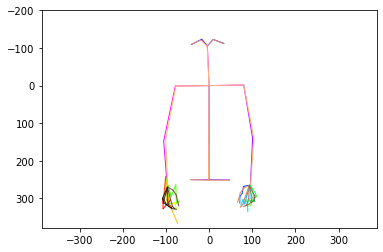

43


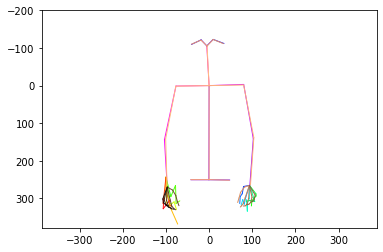

44


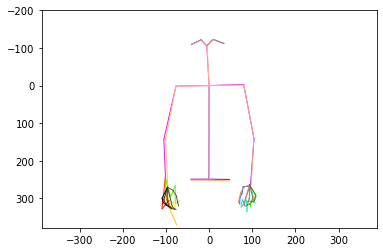

45


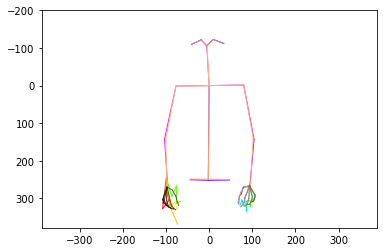

46


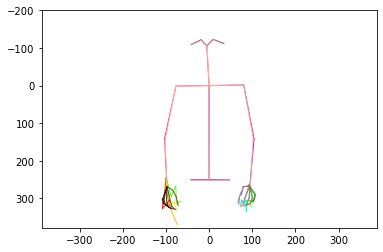

In [7]:
%matplotlib inline

fig = plt.figure()
print(vis_pose.shape[0])
for i, pose in enumerate(vis_pose):
#     clear_output(wait=True)
    print(i)
    ax = plt.subplot(111)
    pose = skel.denormalize_pose(pose, test_dataset.mean, test_dataset.std)
    pose_gt = skel.denormalize_pose(vis_gt[i], test_dataset.mean, test_dataset.std)
    
#     print(pose.shape)
    skel.plot_pose2D(ax, pose)
    skel.plot_pose2D(ax, pose_gt, colormap='copper')
    plt.show()

In [ ]:
lang_embed = torch.FloatTensor(language_encoder(transl_eng))
initial_delta = torch.zeros_like(delta)
print(initial_delta.shape)
combined = torch.cat((pose_seq, initial_delta), dim=-2)

test_output = pose_decoder.sample(lang_embed.cuda(), max(img_seq_len),\
                             combined.view(pose_seq.shape[0], pose_seq.shape[1], -1)[:,0,...].cuda(),\
                             attn=None)

test_output = dataset.unpad_sequence(test_output, img_seq_len).data
vis_pose = pred_pose[:,:57*2].view(-1, 57, 2).cpu().detach()
# vis_pose = test_output.view(test_output.shape[0], -1 , 2).detach().cpu()

for i, pose in enumerate(vis_pose):
#     clear_output(wait=True)
    ax = plt.subplot(111)
#     print(pose.shape)
    pose = skel.denormalize_pose(pose, test_dataset.mean, test_dataset.std)
    pose_gt = skel.denormalize_pose(vis_gt[i], test_dataset.mean, test_dataset.std)
#     print(pose.shape)
    skel.plot_pose2D(ax, pose)
    skel.plot_pose2D(ax, pose_gt, colormap='copper')
    plt.show()